In [ ]:
# Update pip to the latest version
!python -m pip install --upgrade pip

# Install PyTorch and torchvision (Colab often has an older version pre-installed)
!pip install torch torchvision --no-cache-dir

# Install robustbench
!pip install robustbench

# Install foolbox
!pip install foolbox

# Install numpy (Colab has it pre-installed, but this ensures the latest version)
!pip install numpy

# Install autoattack from GitHub (not available on PyPI)
!pip install git+https://github.com/fra31/auto-attack.git


  Cloning https://github.com/fra31/auto-attack.git to /tmp/pip-req-build-t6j_xmyk
  Running command git clone --filter=blob:none --quiet https://github.com/fra31/auto-attack.git /tmp/pip-req-build-t6j_xmyk
  Resolved https://github.com/fra31/auto-attack.git to commit a39220048b3c9f2cca9a4d3a54604793c68eca7e
  Preparing metadata (setup.py) ... done


GPU memory cleared. Initial allocated: 0.00 MiB
Using device: cuda


Downloading...
From (original): https://drive.google.com/uc?id=1-ArD-TugRXUbH3VtM9qnzvby6NvdXNUN
From (redirected): https://drive.google.com/uc?id=1-ArD-TugRXUbH3VtM9qnzvby6NvdXNUN&confirm=t&uuid=560b3459-2bc9-4009-bc0e-131aced080ee
To: /content/models/cifar10/Linf/Cui2023Decoupled_WRN-34-10.pt
100%|██████████| 185M/185M [00:01<00:00, 151MB/s]


Model loaded successfully.


100%|██████████| 170M/170M [00:04<00:00, 35.0MB/s]


Foolbox model initialized.
Attack used: LInfFMNAttack(steps=100, max_stepsize=1.0, init_attack=None, min_stepsize=0.01, binary_search_steps=10, gamma=0.05, p=inf, dual=1)
Batch 1 - Raw batch size: 100
Processing batch 1: 100 samples
Before attack - Allocated: 178.82 MiB, Reserved: 214.00 MiB
Total samples processed so far: 100
After batch 1 - Allocated: 372.35 MiB, Reserved: 740.00 MiB
Batch 2 - Raw batch size: 100
Processing batch 2: 100 samples
Before attack - Allocated: 372.51 MiB, Reserved: 740.00 MiB
Total samples processed so far: 200
After batch 2 - Allocated: 371.18 MiB, Reserved: 740.00 MiB
Batch 3 - Raw batch size: 100
Processing batch 3: 100 samples
Before attack - Allocated: 372.51 MiB, Reserved: 740.00 MiB
Total samples processed so far: 300
After batch 3 - Allocated: 372.35 MiB, Reserved: 740.00 MiB
Batch 4 - Raw batch size: 100
Processing batch 4: 100 samples
Before attack - Allocated: 372.51 MiB, Reserved: 740.00 MiB
Total samples processed so far: 400
After batch 4 - A

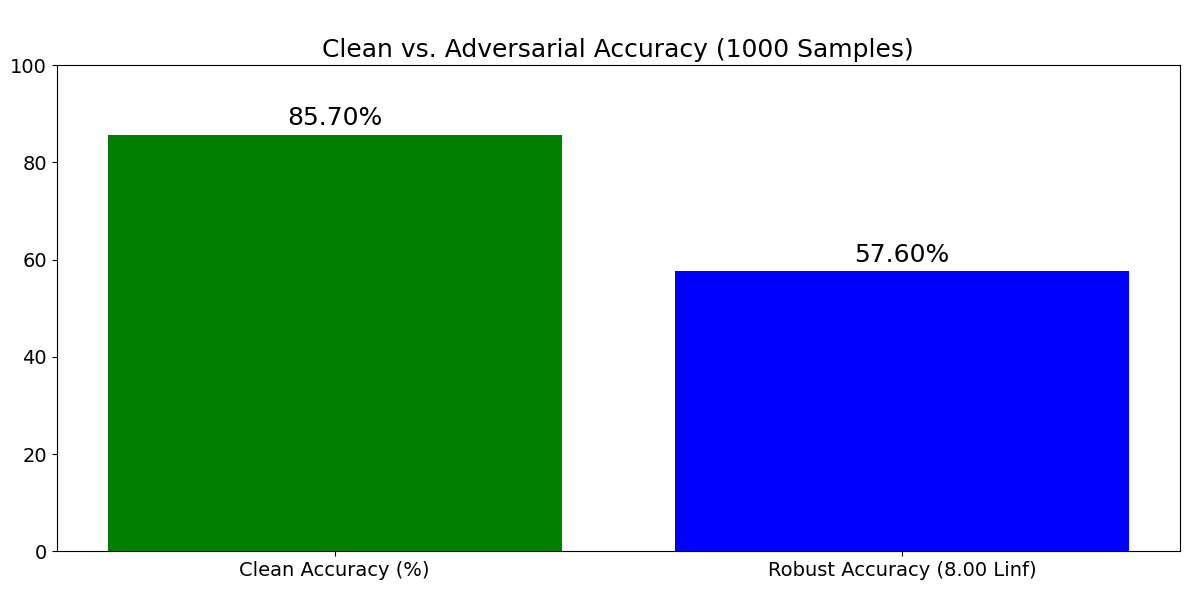

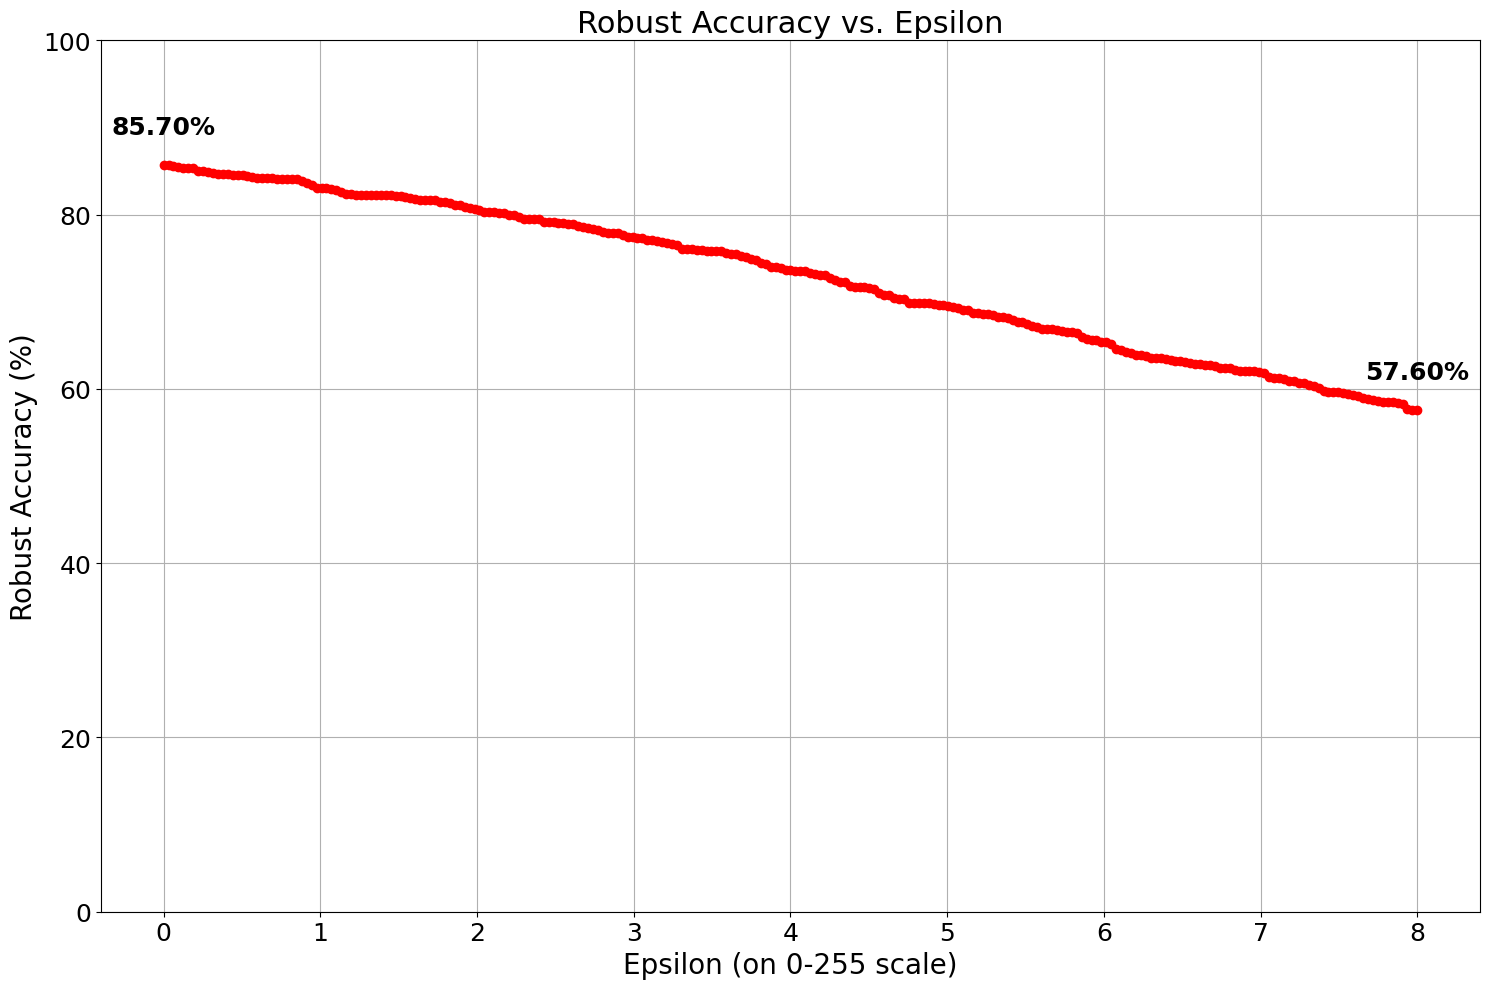

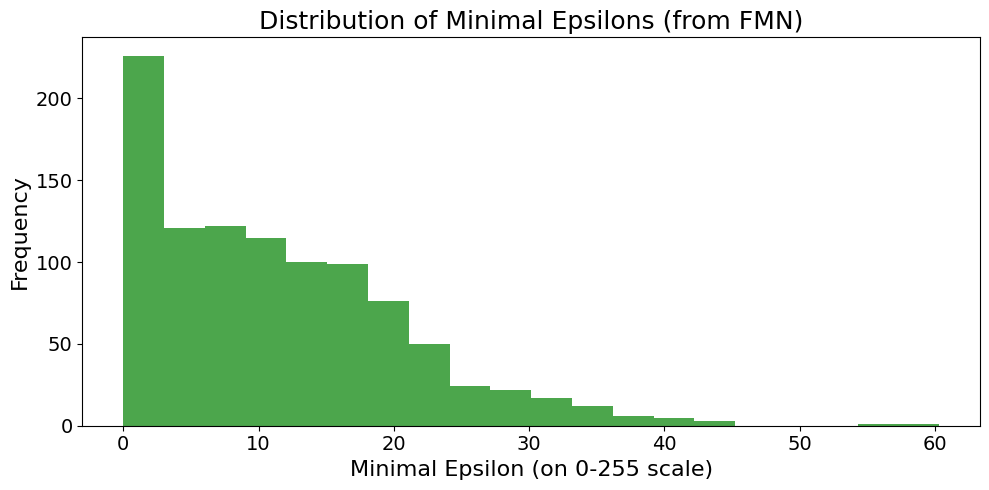

In [ ]:
import torch
from robustbench.utils import load_model
import foolbox as fb
import numpy as np
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os

# Clear GPU memory before starting
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()
    print(f"GPU memory cleared. Initial allocated: {torch.cuda.memory_allocated()/1024**2:.2f} MiB")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

try:
    model = load_model(model_name="Cui2023Decoupled_WRN-34-10", dataset="cifar10", threat_model="Linf").to(device)
    model.eval()
    print("Model loaded successfully.")
except torch.cuda.OutOfMemoryError:
    print("CUDA OOM error while loading model. Switching to CPU.")
    device = torch.device("cpu")
    model = load_model(model_name="Cui2023Decoupled_WRN-34-10", dataset="cifar10", threat_model="Linf").to(device)
    model.eval()
    print("Model loaded successfully on CPU.")

transform = transforms.Compose([transforms.ToTensor()])

# Download CIFAR-10 dataset with error handling
try:
    test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
except Exception as e:
    print(f"Failed to download CIFAR-10 dataset: {e}")
    print("Please ensure you have a stable internet connection and try again.")
    print("Alternatively, manually download the dataset from:")
    print("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz")
    print("Extract it to './data' and set download=False in CIFAR10().")
    raise

test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)  # Batch size 100
fmodel = fb.PyTorchModel(model, bounds=(0, 1))
print("Foolbox model initialized.")

attack = fb.attacks.LInfFMNAttack()
print(f"Attack used: {attack}")

# We will iterate through multiple epsilon values for the robust accuracy vs epsilon plot
epsilon_steps = 255  # Number of epsilon steps for the plot
max_epsilon_benchmark = 8/255  # Standard benchmark max epsilon for CIFAR-10 Linf (8/255)
epsilon_values_for_plot = np.linspace(0, max_epsilon_benchmark, epsilon_steps)


all_adv_preds_at_various_epsilons = {eps: [] for eps in epsilon_values_for_plot}
all_test_labels_at_various_epsilons = {eps: [] for eps in epsilon_values_for_plot}
all_clean_preds = []
all_test_labels_overall = []
all_epsilons_from_fmn = [] # This will store the actual epsilons found by FMN

total_samples_processed = 0

for i, (test_samples, test_labels) in enumerate(test_loader):
    if total_samples_processed >= 1000:  # Process 10 batches of 100 samples each
        break

    print(f"Batch {i+1} - Raw batch size: {test_samples.shape[0]}")
    test_samples = test_samples.to(device)
    test_labels = test_labels.to(device)

    # Limit to remaining samples
    samples_to_process = min(100, 1000 - total_samples_processed)
    test_samples = test_samples[:samples_to_process]
    test_labels = test_labels[:samples_to_process]

    print(f"Processing batch {i+1}: {test_samples.shape[0]} samples")
    if device.type == "cuda":
        print(f"Before attack - Allocated: {torch.cuda.memory_allocated()/1024**2:.2f} MiB, Reserved: {torch.cuda.memory_reserved()/1024**2:.2f} MiB")

    with torch.no_grad():
        clean_preds = fmodel(test_samples).argmax(dim=1)
    all_clean_preds.append(clean_preds.cpu())
    all_test_labels_overall.append(test_labels.cpu())

    try:
        # Run FMN attack to get minimal perturbations
        advs_fmn, _, _ = attack(fmodel, test_samples, test_labels, epsilons=None) # epsilons=None means FMN finds minimal

        # Calculate actual epsilon values found by FMN
        perturbations = torch.abs(advs_fmn - test_samples).amax(dim=(1, 2, 3))
        all_epsilons_from_fmn.extend(perturbations.cpu().numpy())

# For each epsilon threshold, determine adversarial predictions
        for eps_threshold in epsilon_values_for_plot:
            # Clip adversarial examples to the current epsilon threshold
            # This simulates what the adversarial examples would be if the max_epsilon was eps_threshold
            clipped_advs = test_samples + torch.clamp(advs_fmn - test_samples, -eps_threshold, eps_threshold)
            clipped_advs = torch.clamp(clipped_advs, 0, 1) # Ensure valid pixel range

            adv_preds_at_threshold = fmodel(clipped_advs).argmax(dim=1)
            all_adv_preds_at_various_epsilons[eps_threshold].append(adv_preds_at_threshold.cpu())
            all_test_labels_at_various_epsilons[eps_threshold].append(test_labels.cpu())

    except torch.cuda.OutOfMemoryError:
        print(f"CUDA OOM error at batch {i+1}. Switching to CPU.")
        device = torch.device("cpu")
        model = model.to(device)
        fmodel = fb.PyTorchModel(model, bounds=(0, 1))
        test_samples = test_samples.to(device)
        test_labels = test_labels.to(device)

        advs_fmn, _, _ = attack(fmodel, test_samples, test_labels, epsilons=None)

        perturbations = torch.abs(advs_fmn - test_samples).amax(dim=(1, 2, 3))
        all_epsilons_from_fmn.extend(perturbations.cpu().numpy())

        for eps_threshold in epsilon_values_for_plot:
            clipped_advs = test_samples + torch.clamp(advs_fmn - test_samples, -eps_threshold, eps_threshold)
            clipped_advs = torch.clamp(clipped_advs, 0, 1)

            adv_preds_at_threshold = fmodel(clipped_advs).argmax(dim=1)
            all_adv_preds_at_various_epsilons[eps_threshold].append(adv_preds_at_threshold.cpu())
            all_test_labels_at_various_epsilons[eps_threshold].append(test_labels.cpu())

    total_samples_processed += test_samples.shape[0]
    print(f"Total samples processed so far: {total_samples_processed}")

    # Aggressive memory cleanup
    del test_samples, test_labels
    if 'advs_fmn' in locals():
        del advs_fmn
    if 'clean_preds' in locals():
        del clean_preds
    if 'adv_preds_at_threshold' in locals():
        del adv_preds_at_threshold
    gc.collect()
    if device.type == "cuda":
        torch.cuda.empty_cache()
        print(f"After batch {i+1} - Allocated: {torch.cuda.memory_allocated()/1024**2:.2f} MiB, Reserved: {torch.cuda.memory_reserved()/1024**2:.2f} MiB")

if not all_test_labels_overall:
    print("No samples processed. Cannot compute metrics or plot.")
else:
    test_labels_overall = torch.cat(all_test_labels_overall)
    clean_preds_overall = torch.cat(all_clean_preds)
    print("Attack completed for all samples.")
    print(f"Total samples processed: {len(test_labels_overall)}")

    # Calculate clean accuracy
    correct_clean = (clean_preds_overall == test_labels_overall).sum().item()
    clean_acc = correct_clean / len(test_labels_overall) * 100
    print(f"Clean Accuracy: {clean_acc:.2f}%")

# Calculate robust accuracy for the standard benchmark (max_epsilon_benchmark)
    # This requires concatenating predictions specifically for that max_epsilon_benchmark
    if max_epsilon_benchmark in all_adv_preds_at_various_epsilons:
        adv_preds_benchmark = torch.cat(all_adv_preds_at_various_epsilons[max_epsilon_benchmark])
        test_labels_benchmark = torch.cat(all_test_labels_at_various_epsilons[max_epsilon_benchmark])
        correct_adv_benchmark = (adv_preds_benchmark == test_labels_benchmark).sum().item()
        robust_acc_benchmark = correct_adv_benchmark / len(test_labels_benchmark) * 100
        attack_success_rate_benchmark = (adv_preds_benchmark != test_labels_benchmark).float().mean().item() * 100
        print(f"Robust Accuracy under LinfFMN (epsilon={max_epsilon_benchmark*255:.2f}): {robust_acc_benchmark:.2f}%")
        print(f"Attack Success Rate (at epsilon={max_epsilon_benchmark*255:.2f}): {attack_success_rate_benchmark:.2f}%")
    else:
        robust_acc_benchmark = 0 # Fallback if max_epsilon_benchmark was not in the tested epsilons
        attack_success_rate_benchmark = 0


    mean_epsilon_fmn = np.mean(all_epsilons_from_fmn) * 255
    median_epsilon_fmn = np.median(all_epsilons_from_fmn) * 255
    print(f"Mean Minimal Epsilon (from FMN, on 0-255 scale): {mean_epsilon_fmn:.2f}")
    print(f"Median Minimal Epsilon (from FMN, on 0-255 scale): {median_epsilon_fmn:.2f}")

    cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    # Calculate per-class robust accuracy for the benchmark epsilon
    per_class_robust_acc = []
    if max_epsilon_benchmark in all_adv_preds_at_various_epsilons:
        for cls in range(10):
            cls_mask = (test_labels_benchmark == cls)
            if cls_mask.sum() > 0:
                cls_correct = (adv_preds_benchmark[cls_mask] == test_labels_benchmark[cls_mask]).sum().item()
                cls_total = cls_mask.sum().item()
                cls_acc = cls_correct / cls_total * 100
                per_class_robust_acc.append(cls_acc)
            else:
                per_class_robust_acc.append(0)
    else:
        per_class_robust_acc = [0] * 10 # Default if benchmark epsilon wasn't tested

    # Calculate robust accuracy for each epsilon threshold
    robust_accuracies_vs_epsilon = []
    for eps_threshold in epsilon_values_for_plot:
        adv_preds_at_eps = torch.cat(all_adv_preds_at_various_epsilons[eps_threshold])
        test_labels_at_eps = torch.cat(all_test_labels_at_various_epsilons[eps_threshold])
        correct_adv_at_eps = (adv_preds_at_eps == test_labels_at_eps).sum().item()
        robust_acc_at_eps = correct_adv_at_eps / len(test_labels_at_eps) * 100
        robust_accuracies_vs_epsilon.append(robust_acc_at_eps)


    # --- Start of Plotting Section ---

    # Plot 1: Clean vs. Adversarial Accuracy Bar Chart
    plt.figure(figsize=(12, 6))
    metrics = [clean_acc, robust_acc_benchmark]
    metric_names = ['Clean Accuracy (%)', f'Robust Accuracy ({max_epsilon_benchmark*255:.2f} Linf)']
    plt.bar(metric_names, metrics, color=['green', 'blue'])
    plt.ylim(0, 100)
    plt.title(f'\nClean vs. Adversarial Accuracy ({len(test_labels_overall)} Samples)', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    for i, v in enumerate(metrics):
        plt.text(i, v + 2, f'{v:.2f}%', ha='center', fontsize=18)

    plt.tight_layout()
    plt.show()

    # Plot 2: Robust Accuracy vs. Epsilon Line Plot
    plt.figure(figsize=(15, 10))
    epsilons_255 = np.array(epsilon_values_for_plot) * 255
    plt.plot(epsilons_255, robust_accuracies_vs_epsilon, marker='o', color='red')
    plt.xlabel('Epsilon (on 0-255 scale)', fontsize=20)
    plt.ylabel('Robust Accuracy (%)', fontsize=20)
    plt.title('Robust Accuracy vs. Epsilon', fontsize=22)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim(0, 100)
    plt.grid(True)

    # Robust accuracy values on the plot with reference to epsilon
    # Mostra solo etichette sul primo e ultimo punto, con offset verticale dinamico
    for i, (x, y) in enumerate(zip(epsilons_255, robust_accuracies_vs_epsilon)):
      if i == 0 or i == len(epsilons_255) - 1:
          offset = 3 if y < 90 else -5  # se il valore è alto, sposta il testo in basso
          va = 'bottom' if offset > 0 else 'top'
          plt.text(x, y + offset, f'{y:.2f}%', ha='center', va=va,
                  fontsize=18, color='black', fontweight='bold')


    plt.tight_layout()
    plt.show()

    # Plot 3: Histogram plot for Minimal Epsilons
    plt.figure(figsize=(10, 5))
    epsilons_255_fmn = np.array(all_epsilons_from_fmn) * 255 # Define epsilons_255_fmn here
    plt.hist(epsilons_255_fmn, bins=20, color='green', alpha=0.7)
    plt.xlabel('Minimal Epsilon (on 0-255 scale)', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.title('Distribution of Minimal Epsilons (from FMN)', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()

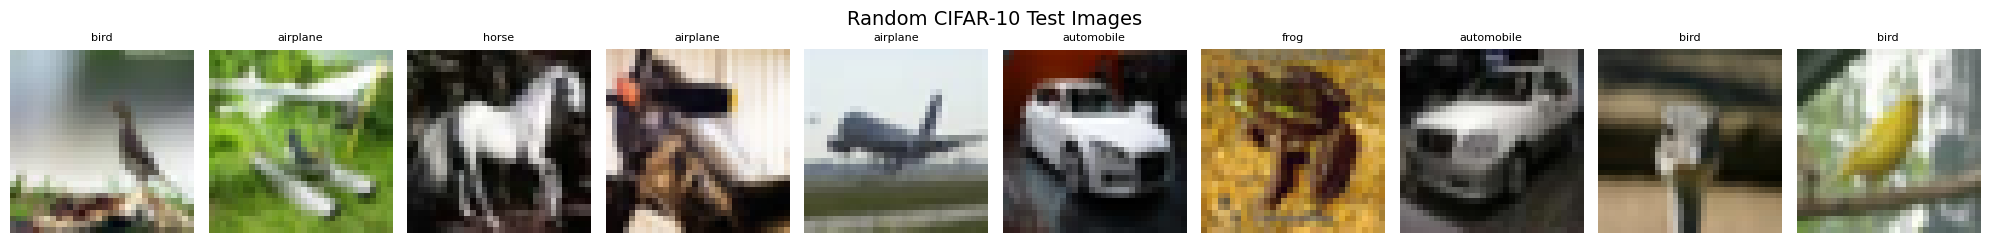

In [ ]:
import matplotlib.pyplot as plt
import random
import torchvision.transforms as transforms

# Classi CIFAR-10
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Numero di immagini da mostrare
num_images = 10

# Indici casuali dal dataset
indices = random.sample(range(len(test_dataset)), num_images)

# Crea una griglia di immagini
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2.5))

for i, idx in enumerate(indices):
    image, label = test_dataset[idx]
    image = image.permute(1, 2, 0).numpy()  # da [C, H, W] a [H, W, C]
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(cifar10_classes[label], fontsize=8)

plt.suptitle("Random CIFAR-10 Test Images", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()